In [1]:
import psycopg2
import pandas as pd
import altair as alt

In [2]:
conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [3]:
def get_dataframe_from_query(cur, query):
    cur.execute(query)
    results = cur.fetchall()
    num_fields = len(cur.description)
    field_names = [i[0] for i in cur.description]
    return pd.DataFrame(results, columns=field_names)

In [4]:
sp_df = get_dataframe_from_query(cur, 'select * from songplays')

In [5]:
sp_df.head(2)

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent
0,0,00:22:07.796000,91,free,None,None,829,"Dallas-Fort Worth-Arlington, TX",Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...
1,1,01:08:41.796000,73,paid,None,None,1049,"Tampa-St. Petersburg-Clearwater, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."


In [40]:
sp_df.shape

(6820, 9)

## We have a dataframe of shape, 6820, but only 1 unique song id/ artist id made it in our songplay table... inspect the data

In [42]:
sp_df['artist_id'].unique()

array([None, 'AR5KOSW1187FB35FF4'], dtype=object)

In [43]:
sp_df['artist_id'].value_counts()

AR5KOSW1187FB35FF4    1
Name: artist_id, dtype: int64

In [44]:
sp_df['song_id'].value_counts()

SOZCTXZ12AB0182364    1
Name: song_id, dtype: int64

In [45]:
sp_df['song_id'].unique()

array([None, 'SOZCTXZ12AB0182364'], dtype=object)

## Lets join with the songs/artist/user table to get detailed information

In [18]:
sp_det_df = get_dataframe_from_query(cur, '''select * from songplays JOIN users ON (songplays.user_id=users.user_id) 
                                             JOIN songs ON (songplays.song_id=songs.song_id) 
                                             JOIN artists ON (songplays.artist_id=artists.artist_id)''')

In [23]:
sp_det_df.head(2)

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent,user_id,...,song_id,title,artist_id,year,duration,artist_id,name,location,latitude,longitude
0,483,21:56:47.796000,15,paid,SOZCTXZ12AB0182364,AR5KOSW1187FB35FF4,818,"Chicago-Naperville-Elgin, IL-IN-WI","""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",15,...,SOZCTXZ12AB0182364,Setanta matins,AR5KOSW1187FB35FF4,0,269.58322,AR5KOSW1187FB35FF4,Elena,Dubai UAE,49.80388,15.47491
1,483,21:56:47.796000,15,paid,SOZCTXZ12AB0182364,AR5KOSW1187FB35FF4,818,"Chicago-Naperville-Elgin, IL-IN-WI","""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",15,...,SOZCTXZ12AB0182364,Setanta matins,AR5KOSW1187FB35FF4,0,269.58322,AR5KOSW1187FB35FF4,Elena,Dubai UAE,49.80388,15.47491


In [46]:
sp_det_df.shape

(463, 24)

In [47]:
sp_det_df.title.unique()

array(['Setanta matins'], dtype=object)

In [49]:
sp_det_df.name.unique()

array(['Elena'], dtype=object)

## We didn't return much data, due to the lack of all of the artists/songs being matched... lets look at that data

In [50]:
artists_df = get_dataframe_from_query(cur, '''select * from artists
                                            ''')

In [51]:
artists_df['name'].unique()[:10]

array(['Casual', 'Clp', 'Planet P Project', 'Tweeterfriendly Music',
       'The Box Tops', 'Jeff And Sheri Easter', 'Rated R', 'JennyAnyKind',
       'Adam Ant', 'Gob'], dtype=object)

In [52]:
songs_df = get_dataframe_from_query(cur, '''select * from songs
                                            ''')

In [53]:
songs_df['title'].unique()[:10]

array(["I Didn't Mean To", 'Insatiable (Instrumental Version)',
       'Pink World', 'Drop of Rain', 'Soul Deep',
       'The Moon And I (Ordinary Day Album Version)',
       'Keepin It Real (Skit)', 'Young Boy Blues', 'Something Girls',
       'Face the Ashes'], dtype=object)

## Lets check that this makes sense.  Using the log files, lets loop through them, and double check that we dont have more matches on our artist names/song titles then we are seeing above

In [54]:
import os
import glob
import pandas as pd
def get_files(filepath):
    all_files = []
    for root, dirs, files in os.walk(filepath):
        files = glob.glob(os.path.join(root,'*.json'))
        for f in files :
            all_files.append(os.path.abspath(f))
    
    return all_files
log_filepath = 'data/log_data'
log_files = get_files(log_filepath)
all_file_artists = []
all_file_songs = []
all_artists = artists_df['name'].unique()
all_songs = songs_df['title'].unique()
for log_file in log_files:
    df = pd.read_json(log_file, lines=True)
    df.head(2)
    held_artists = [artist in all_artists for artist in df['artist'].unique().tolist()]
    all_file_artists.extend(held_artists)
    held_songs = [song in all_songs for song in df['song'].unique().tolist()]
    all_file_songs.extend(held_songs)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/opt/conda/lib/p

In [55]:
pd.Series(all_file_songs).value_counts()

False    6661
True        4
dtype: int64

In [56]:
pd.Series(all_file_artists).value_counts()

False    6133
True       18
dtype: int64

### We can see we are only capturing a very small amount of the artists/songs in the log df with that in the songs df... Lets make sure that our song database actually has all of the data we would expect it to

In [58]:
filepath = 'data/song_data'
song_files = get_files(filepath)
unique_songs_file =[]
unique_artists_file =[]
for song_file in song_files:
    df = pd.read_json(song_file, lines=True)
    df.head()
    unique_songs_file.append(df['title'][0])
    unique_artists_file.append(df['artist_name'][0])

In [59]:
assert set(unique_songs_file) == set(all_songs), 'Print Expected Equal sets of songs'
assert set(unique_artists_file) == set(all_artists), 'Print Expected Equal sets of artists'

### Our unique songs we found from parsing the files, is the same as that in the song/artist databases, so we know we dont have an insertion error

### Most of the interesting questions, like which artists, and songs are being skipped most often we won't be able to answer due to an incomplete dataset.  We can at least look at the top locations, users, and which session saw the most skips.   Additionally we can look at the user agents

In [65]:
sp_df.head(2)

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent
0,0,00:22:07.796000,91,free,None,None,829,"Dallas-Fort Worth-Arlington, TX",Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...
1,1,01:08:41.796000,73,paid,None,None,1049,"Tampa-St. Petersburg-Clearwater, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."


In [68]:
alt.__version__

'1.2.1'

In [97]:
def get_col_counts(df_in, col):
    tdf = pd.DataFrame(sp_df[col].value_counts())
    tdf.reset_index(inplace=True)
    tdf.columns = [col, 'count']
    return tdf

In [98]:
tdf = get_col_counts(sp_df, 'location')

In [99]:
tdf[:10]

,location,count
0,"San Francisco-Oakland-Hayward, CA",691
1,"Portland-South Portland, ME",665
2,"Lansing-East Lansing, MI",557
3,"Chicago-Naperville-Elgin, IL-IN-WI",475
4,"Atlanta-Sandy Springs-Roswell, GA",456
5,"Waterloo-Cedar Falls, IA",397
6,"Lake Havasu City-Kingman, AZ",321
7,"Tampa-St. Petersburg-Clearwater, FL",307
8,"San Jose-Sunnyvale-Santa Clara, CA",292
9,"Sacramento--Roseville--Arden-Arcade, CA",270


In [100]:
tdf[-10:]

,location,count
53,"London, KY",5
54,"Parkersburg-Vienna, WV",5
55,"San Diego-Carlsbad, CA",5
56,"Salt Lake City, UT",4
57,"Raleigh, NC",4
58,"Saginaw, MI",3
59,"Pensacola-Ferry Pass-Brent, FL",3
60,"Elkhart-Goshen, IN",2
61,"Miami-Fort Lauderdale-West Palm Beach, FL",2
62,"Myrtle Beach-Conway-North Myrtle Beach, SC-NC",1


In [101]:
user_df = get_col_counts(sp_df, 'user_agent')

In [102]:
user_df[:10]

,user_agent,count
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",971
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",708
2,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,696
3,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",577
4,"""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5...",573
5,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,443
6,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",427
7,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",419
8,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",319
9,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,310


In [107]:
user_df.iloc[0]['user_agent']

'"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'

In [103]:
user_df[-10:]

,user_agent,count
30,"""Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....",9
31,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,9
32,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",8
33,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3...",5
34,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",5
35,Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko...,3
36,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2
37,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,2
38,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",2
39,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,1


In [108]:
user_id_df = get_col_counts(sp_df, 'user_id')

In [109]:
user_id_df[:10]

,user_id,count
0,49,689
1,80,665
2,97,557
3,15,463
4,44,397
5,29,346
6,24,321
7,73,289
8,88,270
9,36,248


In [110]:
user_id_df[-10:]

,user_id,count
86,64,2
87,56,2
88,11,2
89,22,2
90,27,2
91,39,2
92,59,2
93,79,2
94,45,1
95,87,1


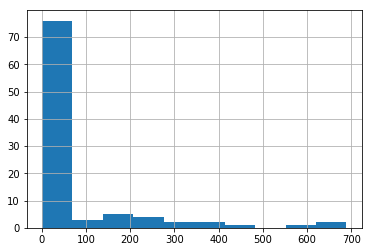

In [120]:
%matplotlib inline
user_id_df['count'].hist()

In [111]:
level_df = get_col_counts(sp_df, 'level')

In [117]:
level_df

,level,count
0,paid,5591
1,free,1229


In [114]:
session_df = get_col_counts(sp_df, 'session_id')

In [115]:
session_df[:10]

,session_id,count
0,589,117
1,984,111
2,324,108
3,672,106
4,221,101
5,293,99
6,1041,92
7,605,85
8,619,81
9,411,80


In [118]:
session_df[-10:]

,session_id,count
766,669,1
767,673,1
768,677,1
769,681,1
770,693,1
771,705,1
772,717,1
773,761,1
774,773,1
775,525,1


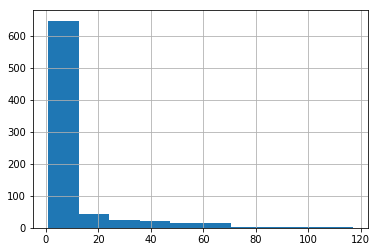

In [121]:
session_df['count'].hist()

## Basic Insights

#### - Our top location is: San Francisco-Oakland-Hayward, CA
#### - We've got a ton of users utilizing: '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"' Which seems to indicate Apple users like Sparkify
#### - We've got more utilization of the platform from our paid users than our free users.
#### - Our user who has skipped the most songs has skipped: 689 times
#### - Our skips are heavily skewed, with a few users skipping more than 100 times, but most < 100
#### - Most user sessions don't last longer than 20 skips, but 1 users has skipped 117 times within a session

In [21]:
conn.close()